In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
#from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
from model import MambaFull, generate_data, seq2seq_generate_tour, compute_tour_length

# Define model parameters and hyperparameters
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

args=DotDict()
#Args for the model

args.bsz=3000
args.d_model = 64
args.coord_dim = 2
args.nb_layers = 3
args.mlp_cls = nn.Identity #nn.Linear
args.city_count = 5
args.deterministic = False #used for sampling from the model

#Args for the training
args.nb_epochs=200
args.test_size=2000
args.nb_batch_per_epoch=6
#args.nb_batch_eval=4 #not used when have fixed test set 
#0 => data will not be recycled and each step new data is generated, however this will make the gpu spend most of the time loading data. Recommeded val is 100
args.recycle_data=2

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#model which will be trained on
model_train = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls).to(device)
#model which will be used as our baseline in the REINFORCE algorithm. This model will not be trained and only used for evaluation
model_baseline = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls).to(device)

#Highlight out if no chekpoint is available
checkpoint = torch.load('mamba/best_checkpoint_3000_6.pt')
model_train.load_state_dict(checkpoint['model_state_dict'])
tot_time_ckpt = 927#checkpoint['tot_time']
epoch = checkpoint['epoch']

model_baseline.load_state_dict(model_train.state_dict())
model_baseline.eval()

cuda


MambaFull(
  (mlp): Identity()
  (norm_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (embedding): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0-2): 3 x Block(
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mixer): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): SiLU()
        (x_proj): Linear(in_features=128, out_features=132, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
    )
  )
  (output_head): Linear(in_features=64, out_features=5, bias=False)
)

In [3]:
# Define a loss function
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = Adam(model_train.parameters(), lr=1e-4)


mean_tour_length_train_list = [] # List to store loss values
mean_tour_length_train_best = float('inf') # Variable to store the best loss value
best_loss = float('inf')

test_data = generate_data(device, args.test_size, args.city_count, args.coord_dim)

start_training_time = time.time()

# Training loop
for epoch in tqdm(range(args.nb_epochs)):
    model_train.train()
    i= 0 # Tracks the number of steps before we generate new data
    start = time.time()
    for step in range(args.nb_batch_per_epoch):

        if i == 0:
            #Inputs will have size (bsz, seq_len, coord_dim)
            inputs = generate_data(device, args.bsz, args.city_count, args.coord_dim)
            i=args.recycle_data
        else: i-=1

        # list that will contain Long tensors of shape (bsz,) that gives the idx of the cities chosen at time t
        tours_train, sumLogProbOfActions = seq2seq_generate_tour(device,model_train,inputs,args.deterministic)
        tours_baseline, _ = seq2seq_generate_tour(device,model_baseline,inputs,args.deterministic)
        #get the length of the tours
        with torch.no_grad():
            L_train = compute_tour_length(inputs, tours_train)
            L_baseline = compute_tour_length(inputs, tours_baseline)
        #print(f"L_train requires_grad: {L_train.requires_grad}")

        # backprop     
        loss = torch.mean( (L_train - L_baseline)* sumLogProbOfActions )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    time_one_epoch = time.time()-start
    time_tot = time.time()-start_training_time + tot_time_ckpt

    ###################
    # Evaluate train model and baseline
    ###################
    model_train.eval()

    # compute tour for model and baseline
    with torch.no_grad():
        tour_train, _ = seq2seq_generate_tour(device,model_train,test_data,deterministic=True)
        tour_baseline, _ = seq2seq_generate_tour(device,model_baseline,test_data,deterministic=True)
        
    # get the lengths of the tours
    L_train = compute_tour_length(test_data, tour_train).mean()
    L_baseline = compute_tour_length(test_data, tour_baseline).mean()

    print(f'Epoch {epoch}, test tour length train: {L_train}, test tour length baseline: {L_baseline}, time one epoch: {time_one_epoch}, time tot: {time_tot}')

    mean_tour_length_train_list.append(L_train)
    # evaluate train model and baseline and update if train model is better
    if L_train < L_baseline:
        model_baseline.load_state_dict( model_train.state_dict() )

    # Save checkpoint every 10,000 epochs
    if L_train < mean_tour_length_train_best:
        mean_tour_length_train_best = L_train
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model_train.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'mean_tour_length_list': mean_tour_length_train_list,
            'args': args,
            'time_tot': time_tot
        }
        torch.save(checkpoint, 'mamba/best_checkpoint_3000_6.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, test tour length train: 2.590090274810791, test tour length baseline: 2.5762550830841064, time one epoch: 13.563519954681396, time tot: 13.569322347640991
Epoch 1, test tour length train: 2.5668349266052246, test tour length baseline: 2.5762550830841064, time one epoch: 8.864842891693115, time tot: 22.64559245109558
Epoch 2, test tour length train: 2.5496468544006348, test tour length baseline: 2.5668349266052246, time one epoch: 8.934917688369751, time tot: 31.793561458587646
Epoch 3, test tour length train: 2.5236048698425293, test tour length baseline: 2.5496468544006348, time one epoch: 9.009155035018921, time tot: 41.01834273338318
Epoch 4, test tour length train: 2.5441837310791016, test tour length baseline: 2.5236048698425293, time one epoch: 9.086895227432251, time tot: 50.322763442993164
Epoch 5, test tour length train: 2.5521974563598633, test tour length baseline: 2.5236048698425293, time one epoch: 9.022921800613403, time tot: 59.55083918571472
Epoch 6, test tour 

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'mean_tour_length_list'])
99


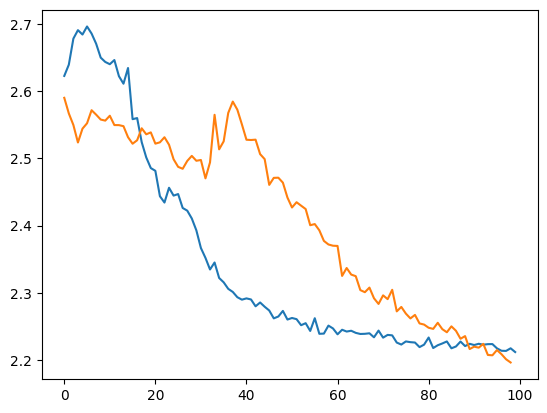

In [7]:
checkpoint = torch.load('mamba/best_checkpoint.pt')
print(checkpoint.keys())
checkpoint2 = torch.load('mamba/best_checkpoint_3000_6.pt')
#model_train.load_state_dict(checkpoint['model_state_dict'])
#model_train.eval()
mean_tour_length_list = [tensor.cpu().numpy() for tensor in checkpoint['mean_tour_length_list']]
mean_tour_length_list2 = [tensor.cpu().numpy() for tensor in checkpoint2['mean_tour_length_list']]
print(checkpoint['epoch'])
plt.plot(mean_tour_length_list)
plt.plot(mean_tour_length_list2)
plt.show()


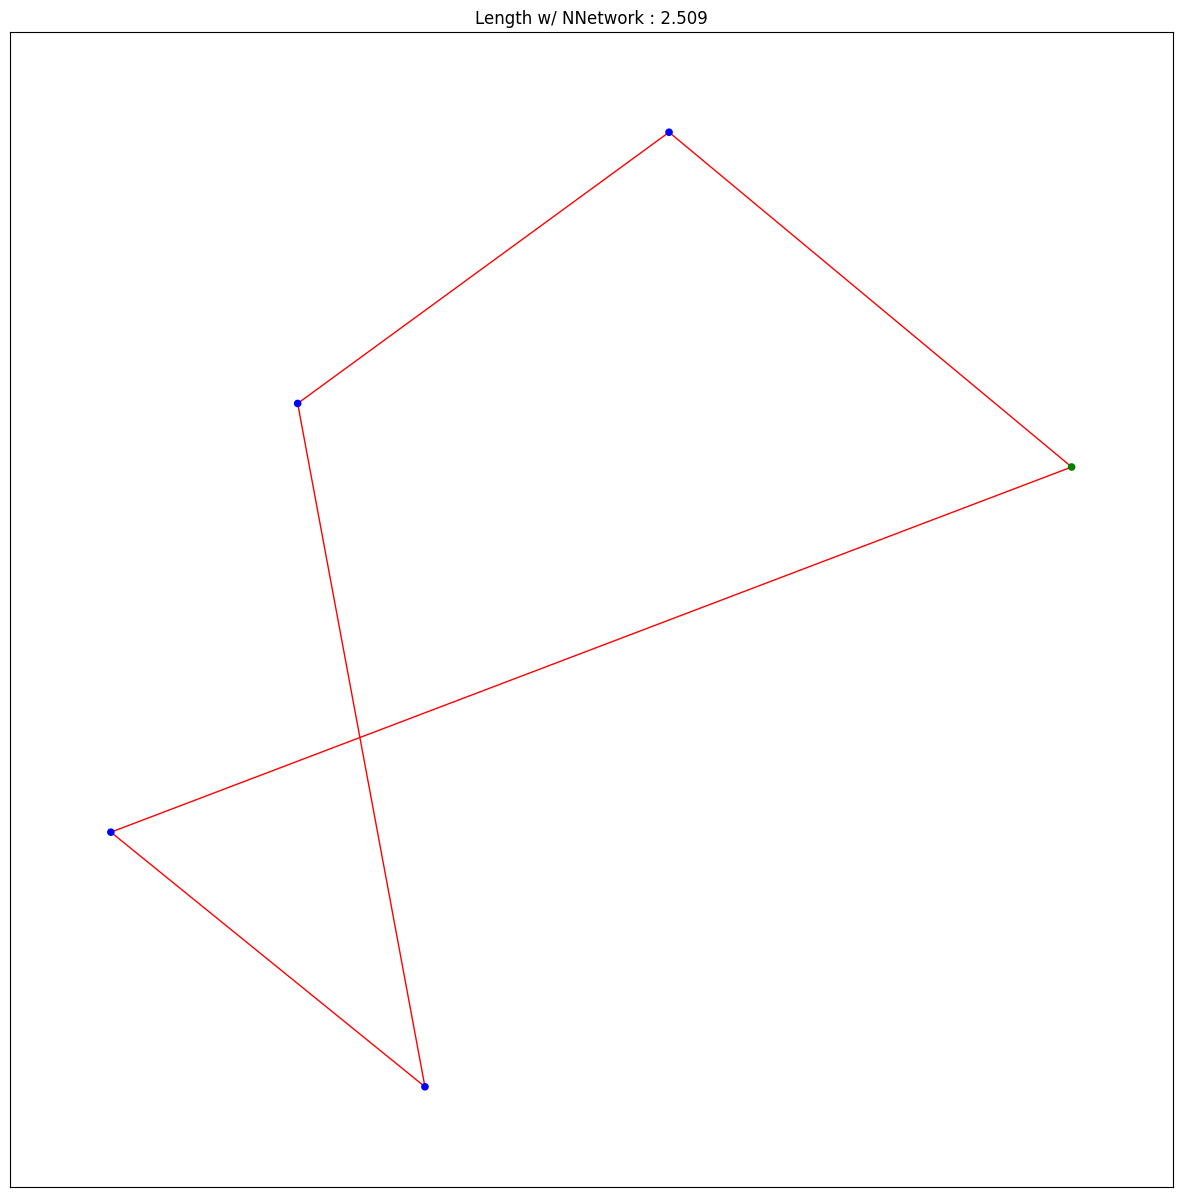

In [5]:
from model import plot_tsp
x = generate_data(device, 1, args.city_count, args.coord_dim)
tour, _ = seq2seq_generate_tour(device,model_train,x,deterministic=True)
plot_tsp(x,tour)